# Project 2 
Engenharia do Conhecimento 22/23

In [1]:
# Let's import what we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing and analising our data

Let's import our data, and remove part of our data as independent validation set

In [2]:
from sklearn.model_selection import train_test_split
bio_data = pd.read_csv("biodegradable_a.csv")

# Load the data into a pandas DataFrame
bio_data = pd.read_csv("biodegradable_a.csv")
bio_data_independent = bio_data.sample(frac=0.2, random_state=42) #take a part of the data as independent
bio_data = bio_data.drop(bio_data_independent.index)


# Split the data into features and target variable
X = bio_data.drop('Biodegradable', axis=1)
y = bio_data['Biodegradable']

X_original = X
n_jobs = 2 #important to change this based on your cpu, higher means more cpu being used. If in doubt use 1


### Plotting each feature against the target

By plotting each feature against our target we can see if our data as many outliers.

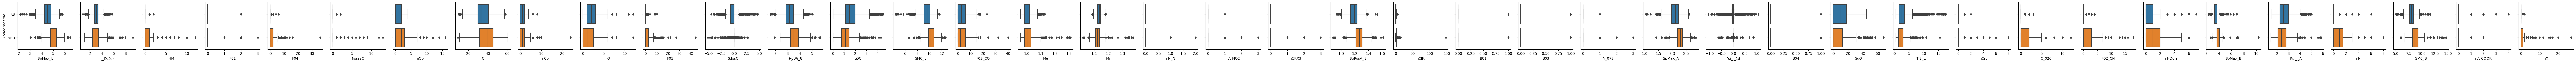

In [3]:
import seaborn as sns

g = sns.PairGrid(bio_data, y_vars="Biodegradable")
g.map_offdiag(sns.boxplot)

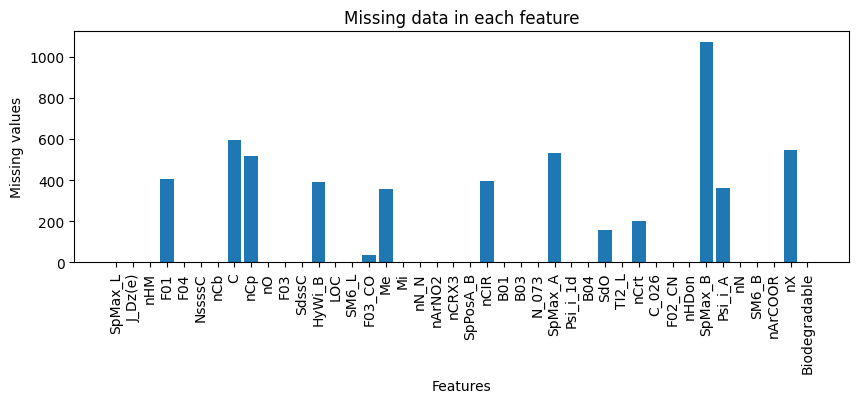

In [4]:
# Count the number of missing values in each column
missing_values = bio_data.isna().sum()

# Create a bar plot to visualize the number of missing values in each column
plt.figure(figsize=(10, 3))
plt.bar(missing_values.index, missing_values.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Missing values')
plt.title('Missing data in each feature')
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_12064\3283662550.py:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variance = bio_data.var()


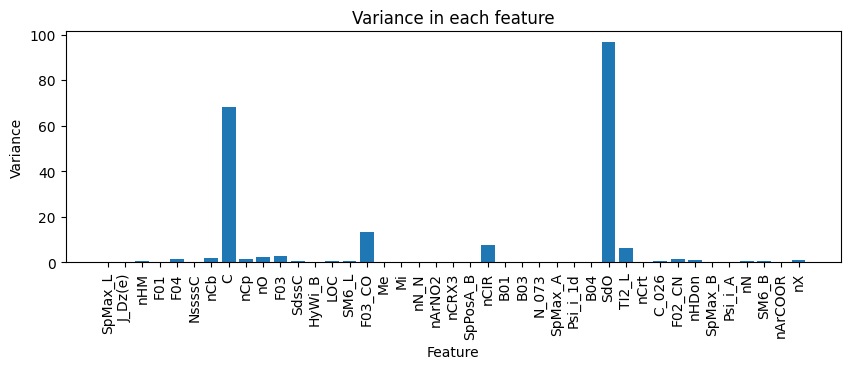

The number of columns with zero variance is : 0


In [5]:
# Calculate the variance of the bio_data dataframe
variance = bio_data.var()

# Create a bar plot to visualize the variance of each column
plt.figure(figsize=(10, 3))
plt.bar(variance.index, variance.values)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.title('Variance in each feature')
plt.show()

zero_var = sum(variance == 0)
print(f"The number of columns with zero variance is : {zero_var}")

## Data processing pipeline

Some have really low variance, but the covariance with the target could be higher. So let's just remove the ones with very small variance.
If you want to test different variance thresholds change the value bellow.

In [6]:
# Create a boolean mask based on the variance to remove low variance features
mask = variance <= 0.001

### Labeling


In [7]:
from sklearn.calibration import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

### Inputing and Scaling

In [8]:
def process_pipeline(imputer, scaler, X):
    #imputthe data
    return scaler.fit_transform(imputer.fit_transform(X))

### Function to find the best imputer scaler combination

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,matthews_corrcoef
# To find best imputer scaler combos before finding best features
def findBestInputScaler(clf, scalers, imputers, X, y):
    best_scaler = None
    best_imputer= None
    best_score = None
    for imputer in imputers:
        for scaler in scalers:
            X_processed = process_pipeline(imputer,scaler, X)
            score = cross_val_score(clf,X_processed,y,scoring=make_scorer(matthews_corrcoef)).mean()
            if (best_score):
                if (best_score < score):
                    best_score = score
                    best_imputer= imputer
                    best_scaler = scaler
            else:
                best_score = score
                best_imputer= imputer
                best_scaler = scaler

    return best_imputer,best_scaler

## Let's define our classifiers

WARNING: Adaboost and Random Forest classifier may take a long time, so commenting them out might be a good idea.

In [10]:

from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Normalizer, PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

classifiers = [KNeighborsClassifier(),DecisionTreeClassifier(),GaussianNB(),SVC(),LogisticRegression(),RandomForestClassifier(),AdaBoostClassifier()]
scalers = [PowerTransformer(), Normalizer(), StandardScaler()]
imputers = [KNNImputer(), SimpleImputer()]

## Let's find the best imputers scalers combos


In [11]:
scalers_votes = dict(zip(scalers, [0]*len(scalers)))
imputers_votes = dict(zip(imputers, [0]*len(imputers)))
# Already ahave a mask
for clf in classifiers:
    imputer, scaler= findBestInputScaler(clf, scalers, imputers, X, y_encoded) # find best imputer
    scalers_votes[scaler] += 1
    imputers_votes[imputer] += 1

best_scaler = max(scalers_votes, key=scalers_votes.get) # find the scaler with most votes
best_imputer= max(imputers_votes, key=imputers_votes.get) # find the imputer with most votes
print(best_imputer, best_scaler)

KNNImputer() StandardScaler()


In [12]:
#Finally let's process our data
X_processed = process_pipeline(best_imputer,best_scaler, X)

## Feature selection

### Correlation based feature selection

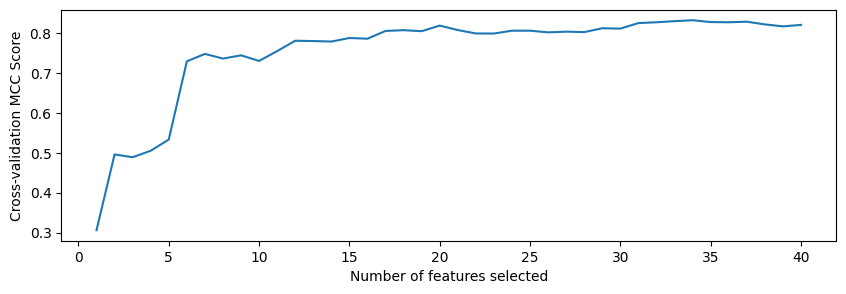

The best number of features is: 34


In [13]:
N,M=X.shape
N,M
v=np.hstack((y_encoded.reshape((N,1)), X_processed))

best_score = 0
arr = np.corrcoef(v.T)[1:, 0]
scores = []
for n in range(1, X_processed.shape[1]): 
    top_indices = sorted(np.argsort(np.abs(arr))[::-1][:n]) # do the absolute, get best indexes in ascending, change to descending get n best
    
    X_processed_c = X_processed[:, top_indices]
    score = cross_val_score(KNeighborsClassifier(), X_processed_c, y_encoded, cv=5,
                            scoring=make_scorer(matthews_corrcoef)).mean()
    scores.append(score)

best_n_features = np.argmax(scores) + 1

plt.figure(figsize=(10, 3))
plt.plot(range(1, X.shape[1]), scores)
plt.ylabel('Cross-validation MCC Score')
plt.xlabel('Number of features selected')
plt.show()

top_indices =  sorted(np.argsort(arr)[::-1][:best_n_features])
print("The best number of features is:" , best_n_features)

### Logistic Feature selection

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.33, random_state=0)
mdl = LogisticRegression(random_state=0).fit(X_train, y_train)

In [15]:
best_mask = mask
best_score = 0
for i in range(1, 20):
    tresh = i / 20.0
    n_mask = abs(mdl.coef_[0]) < tresh # find features that were selected with base calssifier
    score = cross_val_score(DecisionTreeClassifier(), np.delete(X_processed, np.where(n_mask), 1), y_encoded, cv=5,
                                scoring=make_scorer(matthews_corrcoef)).mean()
    if score > best_score:
        best_mask = n_mask
        best_score = score
mask = np.logical_or(mask, best_mask) # save them in the mask

### Decision tree based feature selection

In [16]:
decision_tree_mask = DecisionTreeClassifier().fit(X_processed,y_encoded).feature_importances_ == 0 # mask to remove low importance features

### Sequential feature selection with KNN

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector

#using linear regression for sequential feature selection
knn=KNeighborsClassifier()
sfs = SequentialFeatureSelector(knn, n_features_to_select=best_n_features, direction="backward", n_jobs=n_jobs)
sfs.fit(X_processed, y_encoded)


SequentialFeatureSelector(direction='backward',
                          estimator=KNeighborsClassifier(),
                          n_features_to_select=34, n_jobs=2)

### Separating the data based on the selections

In [18]:
#processing our data

X_processed_c = X_processed[:, top_indices]

# selected features with Decision tree
X_processed_tree = np.delete(X_processed, np.where(decision_tree_mask), 1)

# Get a boolean mask indicating which features were selected
sfs_mask = sfs.get_support(True)

# selected features with SequentialFeatureSelector
X_processed_s = sfs.transform(X_processed)

# selected features with logistic and coeficients
X_processed_l = np.delete(X_processed, np.where(best_mask), 1)

print("Selected Features with correlation: ")
print(list(X.columns[top_indices]))

print("Selected Features with logistic: ")
print(list(np.delete(X.columns, np.where(best_mask))))

print("Selected Features with sequencial feature selection: ")
print(list(X.columns[sfs_mask]))

Selected Features with correlation: 
['SpMax_L', 'J_Dz(e)', 'F01', 'NssssC', 'nCb', 'C', 'nCp', 'nO', 'SdssC', 'HyWi_B', 'LOC', 'SM6_L', 'F03_CO', 'Me', 'Mi', 'nN_N', 'nArNO2', 'nCRX3', 'SpPosA_B', 'nCIR', 'B01', 'B03', 'N_073', 'SpMax_A', 'Psi_i_1d', 'B04', 'SdO', 'TI2_L', 'nCrt', 'nHDon', 'SpMax_B', 'Psi_i_A', 'nArCOOR', 'nX']
Selected Features with logistic: 
['J_Dz(e)', 'nHM', 'F04', 'NssssC', 'nCb', 'C', 'HyWi_B', 'LOC', 'Me', 'Mi', 'nArNO2', 'nCIR', 'SpMax_A', 'nCrt', 'F02_CN', 'Psi_i_A', 'SM6_B', 'nX']
Selected Features with sequencial feature selection: 
['SpMax_L', 'J_Dz(e)', 'nHM', 'NssssC', 'nCb', 'C', 'nCp', 'nO', 'F03', 'SdssC', 'HyWi_B', 'LOC', 'SM6_L', 'F03_CO', 'Me', 'Mi', 'nN_N', 'nArNO2', 'nCIR', 'B01', 'SpMax_A', 'Psi_i_1d', 'B04', 'TI2_L', 'nCrt', 'C_026', 'F02_CN', 'nHDon', 'SpMax_B', 'Psi_i_A', 'nN', 'SM6_B', 'nArCOOR', 'nX']


### Finding the best selection of features

In [19]:
from sklearn.model_selection import cross_val_score

votes = {'correlation':0, 'logistic': 0, 'DecisionTree':0,'sequential': 0, 'all': 0}
selections = list(zip(votes.keys(),[X_processed_c,X_processed_l,X_processed_tree,X_processed_s,X_processed]))
for clf in classifiers:
    estimator = clf
    best_selection = None
    best_score = 0
    for selection in selections:
        score = cross_val_score(estimator, selection[1], y_encoded, cv=5,
                                scoring=make_scorer(matthews_corrcoef)).mean()
        if best_selection is None or score > best_score:
            best_selection = selection
            best_score = score
    votes[best_selection[0]] += 1

best_features = max(votes, key=votes.get)
print(votes)
print(f"The best feature selection based on votes is: {best_features}")

{'correlation': 0, 'logistic': 1, 'DecisionTree': 1, 'sequential': 5, 'all': 0}
The best feature selection based on votes is: sequential


## Finding the best base models

Classifier: KNeighborsClassifier()
Cross-validation MCC score: 0.838
Classifier: DecisionTreeClassifier()
Cross-validation MCC score: 0.826
Classifier: GaussianNB()
Cross-validation MCC score: 0.796
Classifier: SVC()
Cross-validation MCC score: 0.852
Classifier: LogisticRegression()
Cross-validation MCC score: 0.813
Classifier: RandomForestClassifier()
Cross-validation MCC score: 0.864
Classifier: AdaBoostClassifier()
Cross-validation MCC score: 0.824


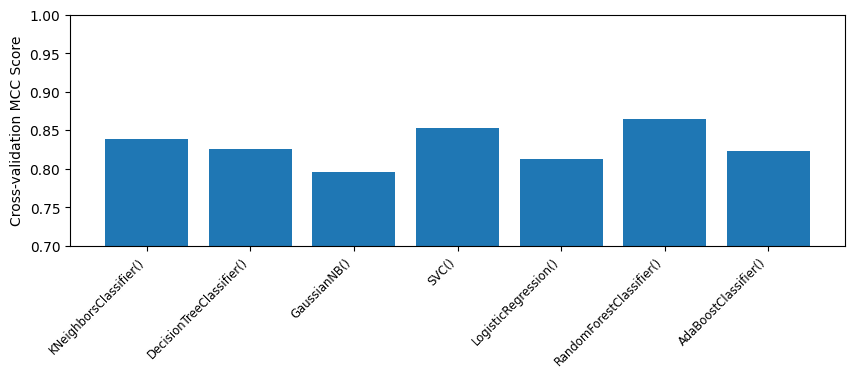

In [20]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

scores = []
names = []

for clf in classifiers:
    estimator = clf
    score = cross_val_score(estimator, X_processed_s, y_encoded, cv=5,
                            scoring=make_scorer(matthews_corrcoef)).mean()
    scores.append(score)
    names.append(f'{clf}')
    print(f"Classifier: {clf}")
    print(f"Cross-validation MCC score: {score:.3f}")

plt.figure(figsize=(10, 3))
plt.ylim(0.7,1)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
)
plt.bar(names, scores)
plt.ylabel('Cross-validation MCC Score')
plt.show()

### Hyper parameter tuning

In [21]:
# Choosing knn
best_estimator =     {
        "name": "KNN",
        "estimator": KNeighborsClassifier(),
        "params": {"n_neighbors": [1,3, 5, 7, 9, 11, 13, 15],
                   "weights":['uniform','distance'],
                   "metric": ['euclidean', 'manhattan', 'chebyshev',"minkowski" ],
                   "p": [1, 2, 3, 4, 5]},
    }


In [22]:
from sklearn.model_selection import GridSearchCV


def get_best_estimator(params, estimator, X, y, n_jobs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
        gs = GridSearchCV(estimator=estimator, param_grid=params, scoring=make_scorer(matthews_corrcoef) ,n_jobs=n_jobs)
        gs=gs.fit(X_train, y_train)

        return gs.best_estimator_

In [23]:
best_estimator_tuned = get_best_estimator(best_estimator["params"], best_estimator["estimator"], X_processed_s, y_encoded, n_jobs=n_jobs)
score = cross_val_score(best_estimator_tuned, X_processed_s, y_encoded, cv=5,
                        scoring=make_scorer(matthews_corrcoef)).mean()
params = best_estimator_tuned.get_params()
print(f"Classifier: {best_estimator['name']}")
for key in best_estimator["params"].keys():
    print(f"\t{key}: {params[key]}")
print(f"Cross-validation MCC score: {score:.3f}\n")


Classifier: KNN
	n_neighbors: 3
	weights: distance
	metric: euclidean
	p: 1
Cross-validation MCC score: 0.850



## Evaluating the best estimator

We will test our independent set, on the MCC, precision, recall and f1.

Recall, precision and f1 score will need to be averaged to check both target classes. Using weighted.

### First we process the whole data
Using the same imputer, scaler and features. And making sure to get the same independent validation set

In [24]:
independent_Size = bio_data_independent.shape[0]
# Split the data into features and target variable
X_ind = bio_data_independent.drop('Biodegradable', axis=1)


#join the whole data, making sure the independent set is anexed at the end of the frame
X_total = pd.concat([X_original, X_ind], axis=0)

X_total = process_pipeline(imputer,scaler, X_total) #impute and scale
X_total = sfs.transform(X_total)

# Re-split on the end to get the same independent validation set
X_train = X_total[:X_total.shape[0]-independent_Size] 
X_ind = X_total[X_total.shape[0]-independent_Size:] 

y_ind = bio_data_independent['Biodegradable']
y_ind = le.fit_transform(y_ind)

best_estimator_tuned.fit(X_train, y_encoded)


KNeighborsClassifier(metric='euclidean', n_neighbors=3, p=1, weights='distance')

### Evaluating our models on the independent set

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score,confusion_matrix

width = 0.2

# create subplots

scores = []
print(best_estimator["name"])

# calculate test scores
for name, X_test, y_test in [("Training set",X_train,y_encoded), ("Independent Validation Set", X_ind, y_ind)]:
    preds_test = best_estimator_tuned.predict(X_test)
    mcc_test = matthews_corrcoef(y_test, preds_test)
    prc_test = precision_score(y_test, preds_test,average="weighted")
    rec_test = recall_score(y_test, preds_test,average="weighted")
    f1_test = f1_score(y_test, preds_test,average="weighted")

    print(name)
    print(f"MCC: {mcc_test:.3f} Precision: {prc_test:.3f} Recall: {rec_test:.3f} F1: {f1_test:.3f}")
    print("Confusion Matrix: ")
    print(pd.DataFrame(confusion_matrix(y_test,preds_test), columns=['NRB','RB'],index=['NRB','RB']),"\n")

KNN
Training set
MCC: 1.000 Precision: 1.000 Recall: 1.000 F1: 1.000
Confusion Matrix: 
     NRB    RB
NRB  583     0
RB     0  3068 

Independent Validation Set
MCC: 0.845 Precision: 0.956 Recall: 0.957 F1: 0.957
Confusion Matrix: 
     NRB   RB
NRB  130   26
RB    13  744 

